## Credit

This implementation was written by [Aaron Berk](http://asberk.ca) and arises from the following publication. 
> Simon Foucart, Deanna Needell, Yaniv Plan, Mary Wootters, "De-biasing low-rank projection for matrix completion," Proc. SPIE 10394, Wavelets and Sparsity XVII, 1039417 (24 August 2017); doi: [10.1117/12.2275004](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/10394/1039417/De-biasing-low-rank-projection-for-matrix-completion/10.1117/12.2275004.short)

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol

%matplotlib inline

In [2]:
import seaborn as sns
import scipy.sparse as spsp
from scipy.sparse.linalg import svds

In [3]:
import mc_util as util

From `util` we make use only of the function `sparseMatComSetup`. It and the relevant auxiliary function have been included below for completion's sake. 
```python
def sparseMatComSetup(r,m,n,p,rng=None):
    """
    sparseMatComSetup(r,m,n,p) returns the necessary components for a simple
    set-up of a matrix completion problem.

    Input: 
      r : rank
      m : number of rows
      n : number of columns
      p : probability of uniform at random observation
    rng : the randomness to use (e.g. 
          lambda d,r : np.random.randint(5, size=(d,r))
          lambda d,r : 2*np.random.randn(d,r)

    Output:
          U : The left [sparse] matrix such that U @ V.T = M
          V : The right [sparse] matrix V such that U @ V.T = M
      Omega : A tuple (I, J) containing a vector of row and column indices
              corresponding to which entries of M were observed.
        obs : A vector of observations corresponding to entries of M at Omega.
    M_Omega : An m-by-n sparse matrix s.t. M_Omega[Omega] == obs.
    """
    if rng is None:
        rng = lambda d,r: np.random.randint(5, size=(d,r))
    k = np.random.binomial(m*n, p)
    Omega = (np.random.randint(m, size=k), np.random.randint(n, size=k))
    U = rng(m,r)
    V = rng(n,r)
    observations = multiplyFromMatIdxList(U, V, Omega)
    M_Omega = csr_matrix((observations, Omega), 
                                shape=(m,n))
    return (U, V, Omega, observations, M_Omega)


def multiplyFromMatIdxList(U, V, Omega):
    """
    multiplyFromMatIdxList(U, V, Omega) returns a vector M_Omega 
    where each entry is given by 
        M_jk := < U_j, V_k >, for (j,k) \in Omega

    Input:
        U : The m-by-r left low-rank matrix
        V : The n-by-r right low-rank matrix
    Omega : A tuple of vectors, the first representing a list of 
            row indices, the second column indices. The tuple formed
            by the i-th element of each vector corresponds to an
            observed element of the low-rank matrix U @ V.T
    """
    return np.array([U[j,:] @ V[k,:] for j,k in zip(*Omega)])
```

In [4]:
r = 3
m = n = 10000
p = 2.1/100 # 2.1 %
U, V, Omega, obs, M_Omega = util.sparseMatComSetup(r, m, n, p)

In [5]:
M = U @ V.T

### Visualize setup

Note that above, the matrices `U` and `V` are `m`-by-`r` and `n`-by-`r` matrices with uniform-at-random integer entries between 0 and 5. Hence, to each entry pair in `Omega` corresponds an entry in `obs` which is an integer between `0` and {{M.max()}} (in this case).

In [17]:
Omega

(array([8908,  348, 9105, ..., 5667, 7608, 8688]),
 array([6716,  607, 6356, ..., 4097, 4500, 9667]))

In [18]:
obs

array([ 7, 12,  3, ..., 15, 20,  2])

In [19]:
M_Omega

<10000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 2079950 stored elements in Compressed Sparse Row format>

Visualize $M$, $M_\Omega$ and its sparsity pattern $1_\Omega$. 

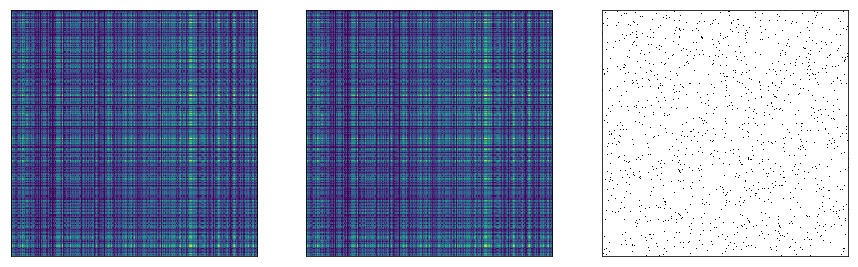

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(M)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.subplot(132);
plt.imshow(U @ V.T)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.subplot(133)
plt.spy(M_Omega.todense())
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

## Method

### Function definitions

In [7]:
def compute_M_hat_0(M_Omega, r):
    if all(not np.issubdtype(M_Omega, t) 
           for t in [np.float, np.complex]):
        M_Omega = M_Omega.astype('d') # convert to np.float64
    u, sig, vt = svds(M_Omega, r)
    return u @ spsp.diags(sig) @ vt

In [8]:
def compute_One_Omega(Omega, shape):
    return spsp.csr_matrix((np.ones(Omega[0].size), Omega), shape=shape)

In [9]:
def compute_W(Omega, shape):
    One_Omega = compute_One_Omega(Omega, shape)
    return compute_M_hat_0(One_Omega, 1)

In [10]:
def compute_M_debias(M_Omega, Omega, r):
    W = compute_W(Omega, M_Omega.shape)
    M_hat_0 = compute_M_hat_0(M_Omega, r)
    return M_hat_0 * (W ** -1)

In [11]:
def TwoInftyNorm(X):
    return (X**2).sum(axis=1).max()**.5

def nuParm(X):
    return max(map(TwoInftyNorm, (X, X.T)))

### Compute $\hat M_{\text{debias}}$

In [12]:
M_hat_debias = compute_M_debias(M_Omega, Omega, r)

Also compute the objects used in the construction of $\hat M_{\text{debias}}$, to be used in visualizing results below. 

In [13]:
M_hat_0 = compute_M_hat_0(M_Omega, r)
One_Omega = compute_One_Omega(Omega, M_Omega.shape)
W = compute_W(Omega, M_Omega.shape)

nu_Omega = nuParm(One_Omega)

## Plot Comparison

Plot $\hat M_{\text{debias}}$ and $M$. In the middle plot, we truncate the colour scale to match the `vmax` and `vmin` of the third plot that visualizes $M$. 

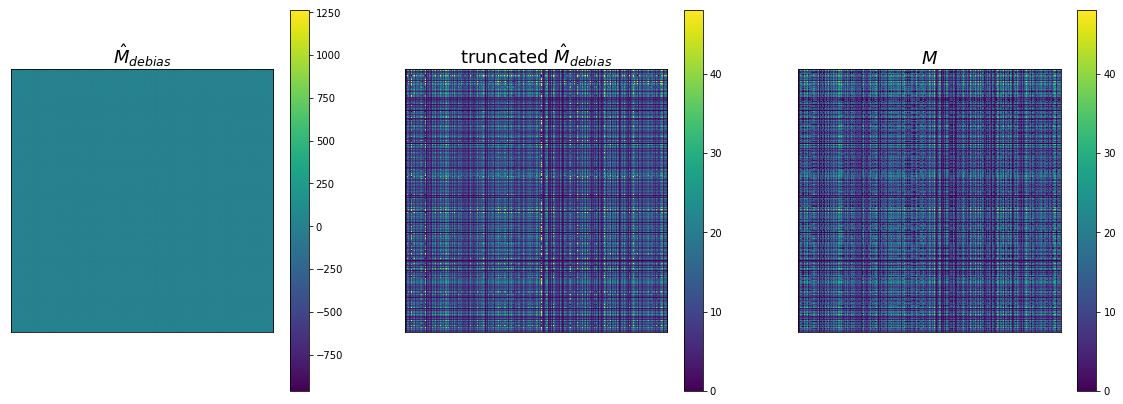

In [14]:
plt.figure(figsize=(20,7))
plt.subplot(131)
plt.imshow(M_hat_debias)
plt.title('$\\hat{M}_{debias}$', size=18)
plt.colorbar()
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.subplot(132)
plt.imshow(M_hat_debias, vmin=M.min(), vmax=M.max())
plt.title('truncated $\\hat{M}_{debias}$', size=18)
plt.colorbar()
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.subplot(133)
plt.imshow(M)
plt.title('$M$', size=18)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.colorbar();

Plot the absolute difference between $\hat M_\text{debias}$ and $M$. The colour bar has been scaled logarithmically to better visualize entries.

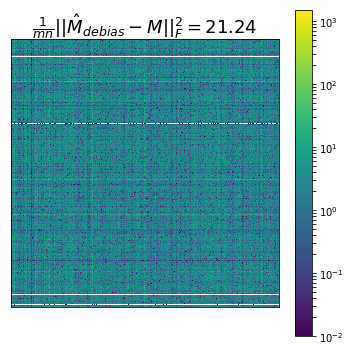

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(np.abs(M_hat_debias - M),
           norm=mcol.LogNorm(vmin=1e-2, vmax=1500))
plt.title('$\\frac{1}{mn}\\|\\|\\hat{M}_{debias} - M \\|\\|_{F}^{2} = ' + 
          '{}'.format((np.linalg.norm(M_hat_debias - M)**2 / (m*n)).round(2)) + 
          '$', size=18);
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.colorbar();